# Advanced Programming : Less Is More
 
Kristóf Fischer, Yiu Kei Tang
 

## Our optimized implementation

In [ ]:
%load_ext cython

In [ ]:
c = [complex(-0.835, -0.2321)]
c

[(-0.835-0.2321j)]

In [ ]:
%%cython -a
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
cimport cython

from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)

def julia_v6(c, int n_iter = 64, size = (500, 500)):
  cdef int frame, i, j, n
  cdef int height = size[0]
  cdef int width = size[1] 

  frames = np.zeros((len(c), size[0], size[1]), dtype=np.intc) 
  cdef int [:,:,::1] frames_memview = frames

  cdef double re_z, im_z, re_c, im_c, re_z_square, im_z_square

  lookup_i = np.zeros(size[0])
  lookup_j = np.zeros(size[1])

  cdef double [::1] lookup_i_memview = lookup_i
  cdef double [::1] lookup_j_memview = lookup_j

  for i in range(height):
      lookup_i_memview[i] = 2-i*4/width
      
  for j in range(width):
      lookup_j_memview[j] = -2+j*4/height

  for frame in range(len(c)):

      re_c = c[frame].real
      im_c = c[frame].imag

      for i in prange(height, nogil=True):
        for j in range(width):
          re_z = lookup_j_memview[j]
          re_z_square = re_z*re_z
          im_z = lookup_i_memview[i]
          im_z_square = im_z*im_z 
          n = 0
          while n < n_iter and re_z_square + im_z_square < 4:
            im_z = 2*re_z*im_z + im_c
            re_z = re_z_square - im_z_square + re_c
            re_z_square = re_z*re_z
            im_z_square = im_z*im_z
            n = n + 1

          if n != n_iter:
            frames_memview[frame, i, j] = n 
            
  return frames

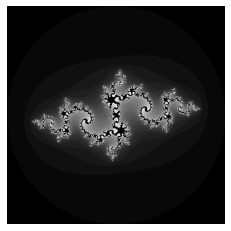

In [ ]:
import matplotlib.pyplot as plt   # Our standard plotting library

frames = julia_v6(c, n_iter=32, size=(500, 500))

plt.figure()
plt.imshow(frames[0], cmap='gray')
plt.axis('off')
plt.show()

## Execution time

v0 execution time ≈ 5s

Attached are the .gif file, and the plotted images at frame 20, 40, 60, 80.

In [ ]:
benchmarking_c = [complex(0.7885*np.cos(angle), 0.7885*np.cos(angle)) for angle in np.linspace(0, 2*np.pi, 10)]
max_iterations = 32

t = %timeit -o julia_v6(benchmarking_c, n_iter = max_iterations, size = (500, 500))
benchmarking=(("Cython + Numpy array + Basic typing + Inner loop + LUTs + Multithreading", t.best))

benchmarking

10 loops, best of 5: 35.3 ms per loop


('Cython + Numpy array + Basic typing + Inner loop + LUTs + Multithreading',
 0.03533084909999999)

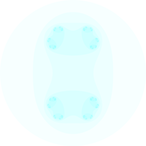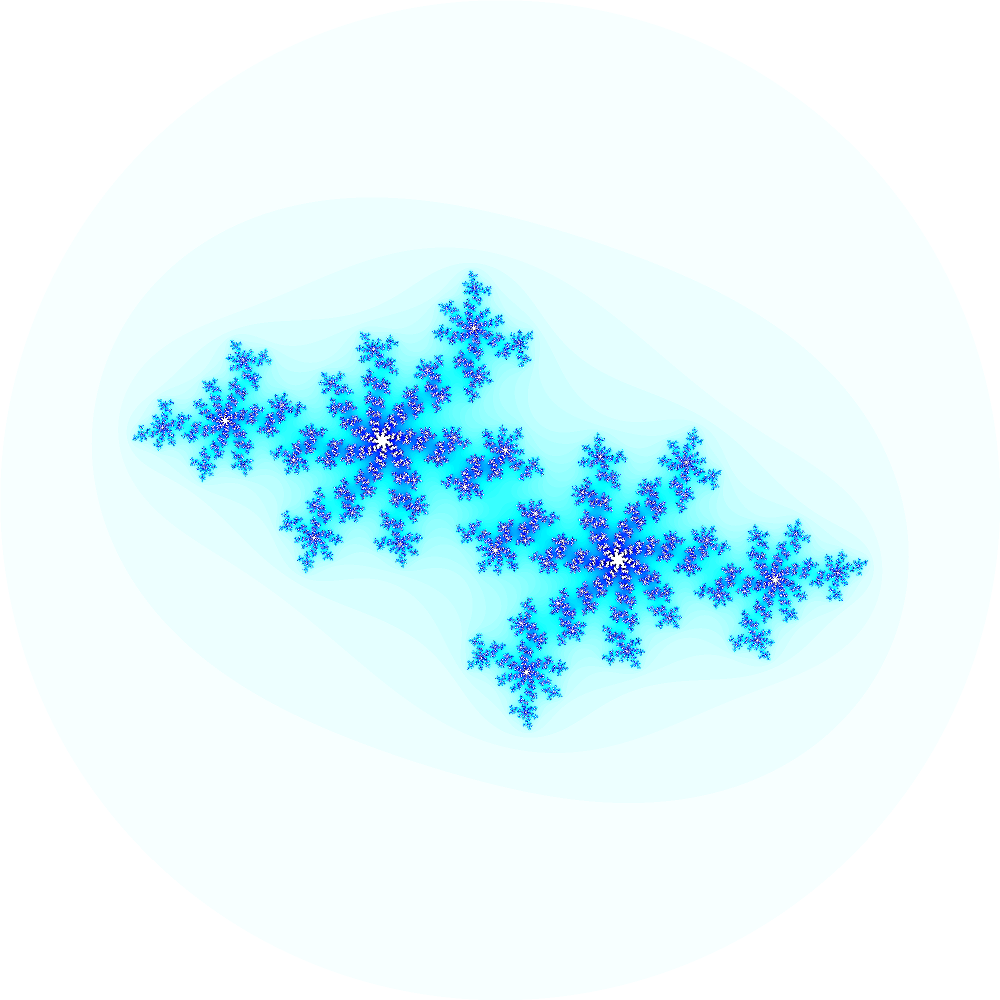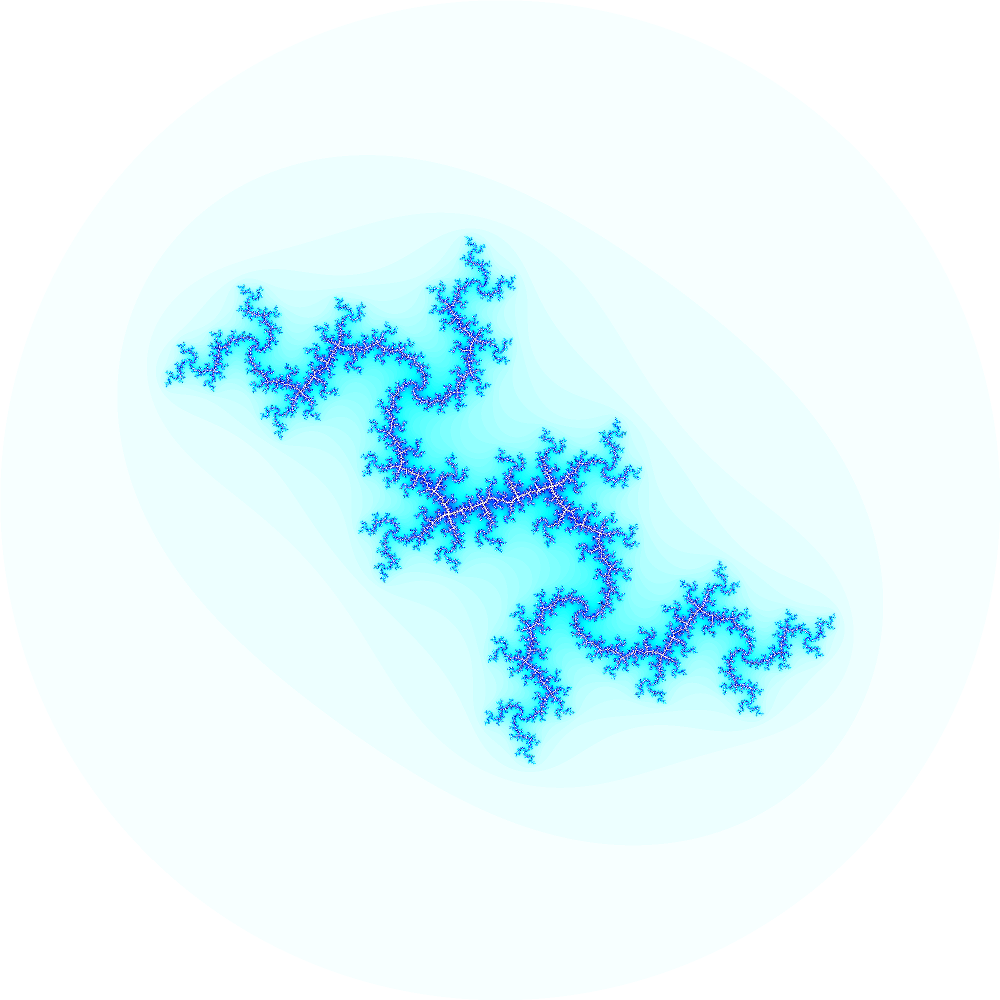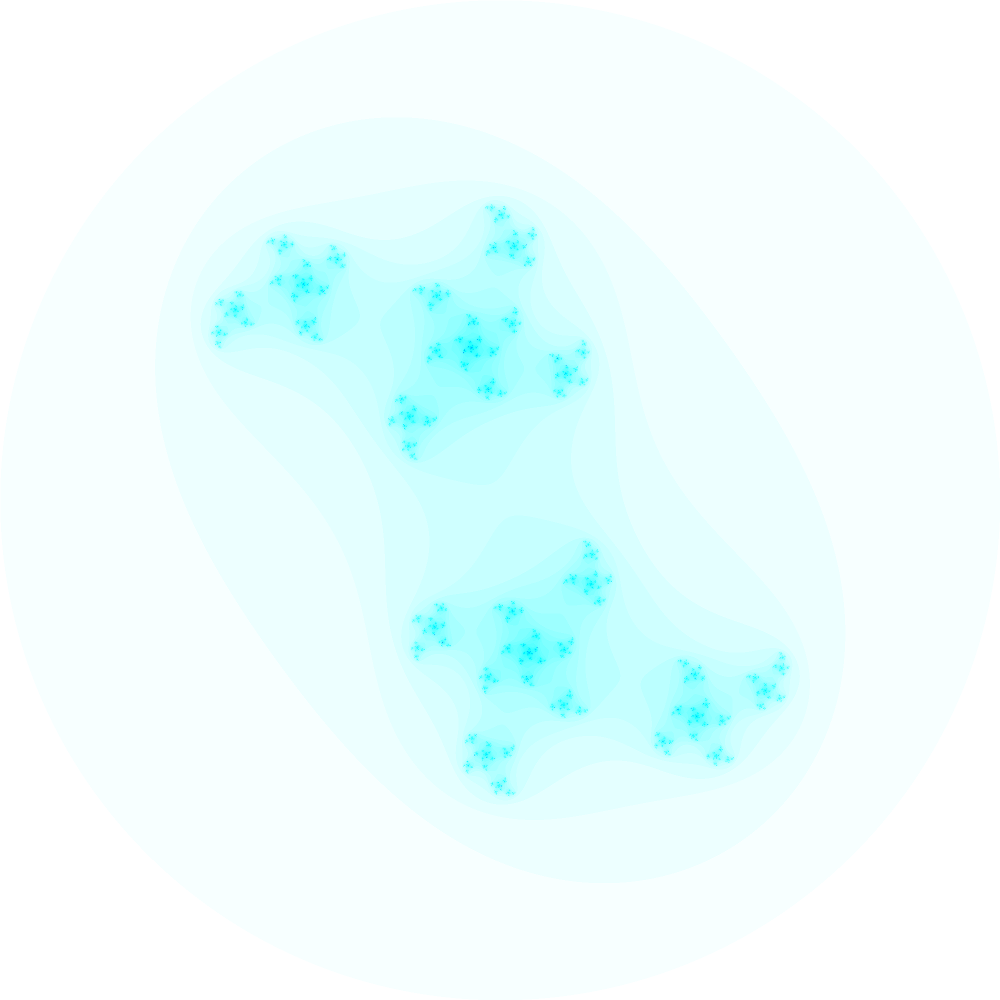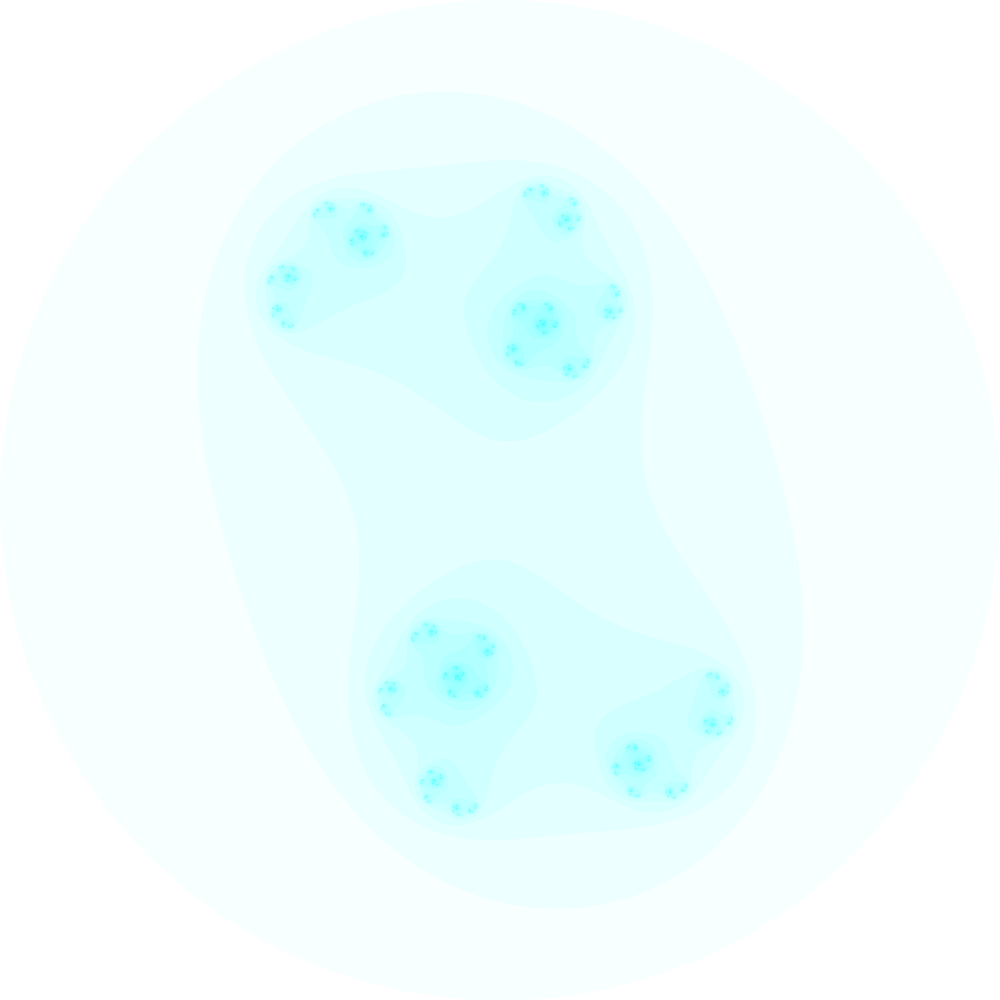